# 学会与 AI 协作
如何与 AI 协作？这也许是未来若干年里最重要的问题。
我们没有标准答案，只有一些实践经验。
如果这些实践对你有所启发，我们将备感荣幸。

注：笔记中提及的 AI，特指大语言模型（LLMs）。

## 0. 开始之前
正式开始前，需做些准备工作。

### 0.1 准备计算智能环境
计算智能环境由算力、算法和数据三类要素构成：
- 计算资源。可以是本地计算机，也可以是云主机或类似 Colab 的 SaaS 服务。
- Python 及三方库、三方 API 服务。
- 三方及自有数据。

In [ ]:
# 安装必要的三方库
%pip install -r requirements.txt

In [ ]:
# 导入三方库

import os
from git import Repo
from datetime import datetime
from dotenv import load_dotenv
import json
import requests
import httpx
import re
from typing import List, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.core.interactiveshell import InteractiveShell
import nbformat
import asyncio

# %ai list
%load_ext jupyter_ai_magics


In [9]:
# 加载本地 .env 文件
load_dotenv()

OPENROUTER_API_URL = os.getenv("OPENROUTER_API_URL")
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")

DIFY_API_URL = os.getenv("DIFY_API_URL")
DIFY_API_KEY = os.getenv("DIFY_BOT_KEY")

GITHUB_URL = os.getenv("GITHUB_URL")
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
GITHUB_USERNAME = os.getenv("GITHUB_USERNAME")
GITHUB_USERNAME_EMAIL = os.getenv("GITHUB_USERNAME_EMAIL")
GITHUB_REPO_NAME = os.getenv("GITHUB_REPO_NAME")

### 0.2 准备生成智能环境
生成智能环境由模型、提示和工具等要素构成：
- 模型（LLMs）。借助 Openrouter 可以方便的调用 OpenAI、Anthropic 等大语言模型。
- 提示（Prompts）。提示是人与 AI 对话/协作的桥梁，用于引导模型生成所需的内容。
- 工具（Tools）。借助 Dify 可以方便的创建和调用比 LLMs 更强大的智能体或工作流。智能体或工作流是模型、工具、知识的有机组合。


In [115]:
# 准备模型、智能体、工作流，以及格式化工具

# Openrouter 模型配置 
OPENROUTER_MODEL = "openai/gpt-4o-mini-2024-07-18"
OPENROUTER_MODELS = [
        #"anthropic/claude-3.5-sonnet:beta",
        #"openai/gpt-4o-2024-11-20",
        "openai/gpt-4o-mini-2024-07-18"
    ]

# 验证 API 令牌是否有效
def validate_api_tokens():
    # 验证 Openrouter API 令牌
    if not OPENROUTER_API_KEY:
        raise ValueError("OPENROUTER_API_KEY 未设置。请在 .env 文件中设置 OPENROUTER_API_KEY。")

    openrouter_headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
        "HTTP-Prompt-Cache": "true"  # 启用 Prompt 缓存
    }
    openrouter_payload = {
        "model": OPENROUTER_MODEL, #"openai/gpt-4o-mini-2024-07-18",
        "messages": [{"role": "user", "content": "测试消息"}]
    }
    try:
        openrouter_response = requests.post(OPENROUTER_API_URL, json=openrouter_payload, headers=openrouter_headers)
        if openrouter_response.status_code == 200:
            print("OPENROUTER_API_KEY 验证成功,API 连接正常。")
        else:
            print(f"Openrouter API 响应异常,状态码:{openrouter_response.status_code}")
            print(f"错误信息:{openrouter_response.text}")
    except requests.RequestException as e:
        print(f"Openrouter API 连接失败:{str(e)}")

    # 验证 Dify API 令牌
    if not DIFY_API_KEY:
        raise ValueError("DIFY_API_KEY 未设置。请在 .env 文件中设置 DIFY_API_KEY。")
    
    dify_headers = {
        "Authorization": f"Bearer {DIFY_API_KEY}",
        "Content-Type": "application/json"
    }
    dify_payload = {
        "inputs": {"etf_code": "FPE"},
        "query": "综述代码为 FPE 的 ETF",
        "response_mode": "blocking",
        "conversation_id": "",
        "user": "api_validator"
    }
    """
    try:
        dify_response = requests.post(DIFY_API_URL, json=dify_payload, headers=dify_headers)
        if dify_response.status_code == 200:
            print("DIFY_API_KEY 验证成功,API 连接正常。")
        else:
            print(f"Dify API 响应异常,状态码:{dify_response.status_code}")
            print(f"错误信息:{dify_response.text}")
    except requests.RequestException as e:
        print(f"Dify API 连接失败:{str(e)}")
    """
    
async def call_llm(messages: List[Dict[str, str]], model: str = OPENROUTER_MODEL) -> str:
    """
    调用指定的 LLM API 并返回响应。

    :param messages: 消息列表，包含系统和用户消息
    :param model: 要调用的模型名称
    :return: 模型的响应内容
    """
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
        "HTTP-Prompt-Cache": "true"  # 启用 Prompt 缓存
    }

    payload = {
        "model": model,
        "messages": messages
    }

    try:
        async with httpx.AsyncClient() as client:
            response = await client.post(OPENROUTER_API_URL, json=payload, headers=headers)
        response.raise_for_status()
        result = response.json()
        return result['choices'][0]['message']['content']
    except httpx.HTTPStatusError as e:
        print(f"HTTP error occurred: {e}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

async def call_multiple_models(messages: List[Dict[str, str]], models: List[str]) -> Dict[str, str]:
    """
    调用多个 LLM 模型并收集它们的响应。

    :param messages: 消息列表，包含系统和用户消息
    :param models: 模型名称列表
    :return: 包含每个模型响应的字典
    """
    tasks = [call_llm(messages, model=model) for model in models]
    
    # 并发调用所有模型
    responses = await asyncio.gather(*tasks, return_exceptions=True)
    
    extracted_data = {}
    for model, response in zip(models, responses):
        if isinstance(response, Exception):
            extracted_data[model] = f"Error: {str(response)}"
        else:
            extracted_data[model] = response
    return extracted_data

def format_llm_response(response: str) -> dict:
    """
    格式化 LLM 返回的响应，确保它是一个有效的 JSON 对象。
    """
    # 移除可能的 markdown 代码块标记
    response = re.sub(r'```json\s*', '', response)
    response = re.sub(r'\s*```', '', response)

    # 尝试直接解析 JSON
    try:
        parsed_response = json.loads(response)
        if isinstance(parsed_response, dict):
            return parsed_response
    except json.JSONDecodeError:
        pass

    # 如果直接解析失败，尝试提取并解析嵌套的 JSON
    try:
        match = re.search(r'\{.*\}', response, re.DOTALL)
        if match:
            parsed_response = json.loads(match.group())
            if isinstance(parsed_response, dict):
                return parsed_response
    except json.JSONDecodeError:
        pass

    # 如果所有尝试都失败，返回原始响应作为字符串值的字典
    return {"raw": response}

validate_api_tokens()
print("模型准备完毕。")

OPENROUTER_API_KEY 验证成功,API 连接正常。
模型准备完毕。


In [ ]:
class NotebookUpdater:
    def __init__(self, notebook_path='CollaborateWithAI.ipynb'):
        """Initialize the NotebookUpdater."""
        self.notebook_path = notebook_path

    def _extract_heading_info(self, marker):
        """Extract heading level and title from a markdown heading."""
        if isinstance(marker, tuple):
            marker = marker[0]
        
        marker = str(marker).strip()
        heading_level = len([c for c in marker if c == '#'])
        remaining_text = marker.strip('#').strip()
        
        try:
            # Split by first space to separate section number from title
            if ' ' in remaining_text:
                section_number, title_text = remaining_text.split(' ', 1)
                # Only treat it as section number if it contains digits
                if not any(c.isdigit() for c in section_number):
                    title_text = remaining_text
                    section_number = ''
            else:
                section_number = remaining_text if any(c.isdigit() for c in remaining_text) else ''
                title_text = remaining_text if not section_number else ''
        except:
            section_number = ''
            title_text = remaining_text
            
        return heading_level, section_number, title_text

    def _increment_section_number(self, section_number, index):
        """
        Increment section number based on index.
        Examples:
            "1.2.1" -> "1.2.1.1", "1.2.1.2", etc.
            "1.2" -> "1.2.1", "1.2.2", etc.
        """
        if not section_number:
            return str(index)
        return f"{section_number}.{index}"

    def _adjust_content_headings(self, content, marker_level):
        """Adjust all content headings to be one level deeper than the marker level."""
        if not isinstance(content, str):
            content = str(content)
            
        lines = content.split('\n')
        adjusted_lines = []
        
        for line in lines:
            if line.strip().startswith('#'):
                heading_text = line.strip('#').strip()
                adjusted_lines.append(f"{'#' * (marker_level + 1)} {heading_text}")
            else:
                adjusted_lines.append(line)
                
        return '\n'.join(adjusted_lines)

    def _find_section_position(self, nb, marker):
        """Find the appropriate position to insert content."""
        if isinstance(marker, tuple):
            marker = marker[0]
        marker = str(marker).strip()
        
        heading_info = marker.split(' ', 1)
        section_text = heading_info[1] if len(heading_info) > 1 else marker

        for idx, cell in enumerate(nb.cells):
            if cell.cell_type == 'markdown' and section_text in cell.source:
                next_idx = idx + 1
                current_level = cell.source.count('#')
                
                while next_idx < len(nb.cells):
                    next_cell = nb.cells[next_idx]
                    if (next_cell.cell_type == 'markdown' and 
                        next_cell.source.count('#') <= current_level):
                        break
                    next_idx += 1
                return next_idx
                
        return len(nb.cells)

    async def update_markdown(self, title, content):
        """
        Update an existing markdown cell in the notebook or create a new one.
        This method finds and updates a cell with the exact title match, or creates a new cell if not found.
        """
        try:
            with open(self.notebook_path, 'r', encoding='utf-8') as f:
                nb = nbformat.read(f, as_version=4)
            
            # Get base heading level from title
            heading_level, _, _ = self._extract_heading_info(title)
            
            # Adjust content headings
            adjusted_content = self._adjust_content_headings(content, heading_level)
            
            # Create final markdown content
            markdown_content = f"{title}\n\n{adjusted_content}"
            
            # Look for the cell with matching title to update
            title_without_tags = title.split('（')[0].strip()
            updated = False
            insert_index = len(nb.cells)  # Default to end of notebook
            
            for idx, cell in enumerate(nb.cells):
                if cell.cell_type == 'markdown' and title_without_tags in cell.source:
                    cell.source = markdown_content
                    updated = True
                    break
                # Keep track of where the section should be inserted
                if (cell.cell_type == 'markdown' and 
                    cell.source.startswith('#') and 
                    title_without_tags > cell.source.split('\n')[0]):
                    insert_index = idx + 1
            
            if updated:
                print(f"✅ Updated existing content for {title}")
            else:
                # Create new cell if not found
                new_cell = nbformat.v4.new_markdown_cell(markdown_content)
                nb.cells.insert(insert_index, new_cell)
                print(f"✅ Created new cell for {title}")
            
            with open(self.notebook_path, 'w', encoding='utf-8') as f:
                nbformat.write(nb, f)
            return True
            
        except FileNotFoundError:
            print(f"❌ Could not find notebook: {self.notebook_path}")
            return False
        except Exception as e:
            print(f"❌ Error updating notebook: {str(e)}")
            return False

    async def insert_markdown(self, title, content, position_marker):
        """
        Insert a new markdown cell after the specified marker.
        This method creates a new cell without modifying existing ones.
        """
        try:
            with open(self.notebook_path, 'r', encoding='utf-8') as f:
                nb = nbformat.read(f, as_version=4)
            
            # Get marker level for content adjustment
            marker_level, _, _ = self._extract_heading_info(title)
            
            # Adjust content headings
            adjusted_content = self._adjust_content_headings(content, marker_level)
            
            # Create final markdown content
            markdown_content = f"{title}\n\n{adjusted_content}"
            
            # Find position to insert
            insert_index = self._find_section_position(nb, position_marker)
            
            # Insert new cell
            new_cell = nbformat.v4.new_markdown_cell(markdown_content)
            nb.cells.insert(insert_index, new_cell)
            
            with open(self.notebook_path, 'w', encoding='utf-8') as f:
                nbformat.write(nb, f)
            
            print(f"✅ Inserted content for {title}")
            return True
            
        except FileNotFoundError:
            print(f"❌ Could not find notebook: {self.notebook_path}")
            return False
        except Exception as e:
            print(f"❌ Error inserting content: {str(e)}")
            return False

    async def update_with_responses(self, extracted_data: Dict[str, str], base_marker: str):
        """
        Update existing notebook cells with responses from models.
        For each model's response, updates or creates a cell with unique section number.
        
        Args:
            extracted_data (Dict[str, str]): Dictionary with model names as keys and responses as values
            base_marker (str): The base marker indicating section location (e.g., "#### 1.2.1")
        """
        if not extracted_data:
            print("❌ No model responses provided")
            return False
            
        # Extract heading components
        heading_level, section_number, title_text = self._extract_heading_info(base_marker)
        
        success = True
        for i, (model, response) in enumerate(extracted_data.items(), 1):
            # For multiple models, create sequential section numbers at the same level
            if len(extracted_data) > 1:
                if '.' in section_number:
                    # Replace the last number in the section
                    parts = section_number.rsplit('.', 1)
                    new_section = f"{parts[0]}.{i}"
                else:
                    new_section = str(i)
                model_marker = f"{'#' * heading_level} {new_section}"
                if title_text:
                    model_marker = f"{model_marker} {title_text}"
            else:
                model_marker = base_marker
                
            # Create title with model tag
            title = f"{model_marker}（{model} 生成）"
            
            # Update notebook with the response
            result = await self.update_markdown(title, response)
            if not result:
                print(f"❌ Failed to update content for model: {model}")
                success = False
                
        return success

    async def insert_with_responses(self, extracted_data: Dict[str, str], base_marker: str):
        """
        Insert multiple models' responses as new sections after the marker.
        
        Args:
            extracted_data (Dict[str, str]): Dictionary with model names as keys and responses as values
            base_marker (str): The marker to insert after (e.g., "### 1.2")
        """
        if not extracted_data:
            print("❌ No model responses provided")
            return False
            
        # Extract base heading information
        heading_level, section_number, title_text = self._extract_heading_info(base_marker)
        
        for i, (model, response) in enumerate(extracted_data.items(), 1):
            # Create new section number
            new_section = self._increment_section_number(section_number, i)
            
            # Create title for this model's response
            if title_text:
                title = f"{'#' * (heading_level + 1)} {new_section} {title_text}（{model} 生成）"
            else:
                title = f"{'#' * (heading_level + 1)} {new_section}（{model} 生成）"
            
            # Insert this model's response
            await self.insert_markdown(title, response, base_marker)

# Example usage:
"""
updater = NotebookUpdater()

# For updating existing content:
base_marker = "#### 1.2.1"
await updater.update_with_responses(extracted_data, base_marker)

# For inserting new sections:
base_marker = "### 1.2"
await updater.insert_with_responses(extracted_data, base_marker)
"""

In [97]:
scholar_system_prompt = f"""
你是一位"Scholar", 博览群书, 熟悉 DDC 分类法。你的任务是针对用户提出的"{{subject}}是什么", 提供多维度信息, 支持用户深入理解该主题。

工作流程指引：
1. 以表格形式, 基于拉米(Bernard Lamy)框架提供以下信息:
    - 类别(Genre): 该{{subject}}在 DDC 分类中所属的类别
    - 种差(Differentia): 在该类别中,与其他事物相比{{subject}}有何独特之处?
    - 部分(Parts): {{subject}}由哪些部分构成?
    - 定义(Definition): {{subject}}的基本定义是什么?
    - 词源(Etymology): 该词的词源、历史与演变如何?
    - 反义词(Antonyms): 有哪些与{{subject}}相对立的概念?
    - 原因与由来(Cause): {{subject}}是由什么产生或发展而来的?
    - 结果与衍生物(Effect): {{subject}}会引发什么结果或衍生物?
2. 小结与延伸:
    - 生成对"{{subject}}是什么"的独立见解, 帮助用户从更广阔的视角理解{{subject}}。
    - 提出1-2个能激发进一步思考的问题, 引导用户深入探究。
"""

modeling_system_prompt = f"""
你是 Scott E. Page, 《The Model Thinker: What You Need to Know to Make Data Work for You》一书的作者, 一位专注于复杂系统和多模型思维方法的专家。
你的任务是支持用户构建出有用的模型，用于深入理解或科学应对复杂的事物、现象、系统或问题。

# Strategy #  
1. 界定问题
- 设定建模目的：该模型能解决什么具体问题？
- 设定用途：该模型模型擅长推理、解释、设计、交流、行动、预测，还是探索？
- 设定边界：该模型将包含和排除哪些要素？
2. 选择建模方法并建模
- 具身法（embodiment approach）。捕捉系统的关键部分并将其具象化。对于不必要的维度和属性，要么剥离，要么将它们整合在一起考虑。
- 类比法（analogy approach）。对现实进行类比与抽象，致力于刻画过程、系统或现象的本质。为了估计一头牛身上牛皮的面积，我们可以假设那头牛是球形的。
- 另类现实法（alternative reality approach）。刻意不去表征现实，而是建立一个用来探索思想的虚拟世界。
3. 审查模型
- 简化性。模型应从现实世界中提取关键要素，去除冗余的复杂细节。     
- 形式化。在表达模型时，需使用数学公式或图表。对关键参数、变量和关系进行精确定义，避免仅以文字描述。     
- 不完美性。强调所有模型都有局限性与偏差。明示模型可能的适用范围与条件，并说明何时或何种情形下模型的有效性受到影响。 
- 优先选用《The Model Thinker》或已被学术界广泛论证过的成熟模型。
#############

# Response # 
- 概述建模思路及适用的模型类别（如贝叶斯模型、博弈论模型、动力系统模型、网络模型等）。  
- 给出数学表述或图示构思（例如定义变量、给出基本方程或关系图）。数学公式直接使用 LaTeX $$格式块表达。
- 详细解释模型涵义，以及隐含的边界条件与简化假设。  
- 明示模型不完美性的根源，并探讨这些不完美性会如何影响模型的使用。
#############
"""

draft_proposal_system_prompt = f"""
你是一位精通人机协作的咨询顾问. 你的任务是帮助普通人提升与 AI 的协作水平, 释放协作绩效潜能(Performance = potential - interference).
请参考以下假设及提案框架, 回答: {{subject}}? 

## 假设 ## 
1. 人机协作模型: $$ P = \\sum_{{i=1}}^n[c_i w_i \\max(h_i, a_i) + (1-c_i) w_i \\min(h_i, a_i)] $$
    - 人与 AI 按 KSME(Knowledge/Skill/Motivation/Environment) 四个维度加权求和的方式协作；
    - $c$ 为平衡系数，代表协作双方优势的可转化程度。
2. 普通人的 KSME 维度参数: 0.5, 0.5, 0.9, 0.5
3. AI 的 KSME 维度参数: 0.9, 0.8, 0.5, 0.8
4. 生活事务所需能力的 KSME 权重: 0.1, 0.1, 0.4, 0.4
5. 缺省的平衡系数 KSME 各维度参数: 0.5, 0.5, 0.5, 0.5
6. 期望的平衡系数 KSME 各维度参数: 0.72, 0.64, 0.9, 0.64

假设的结论：
通过模型推演可知: 对日常生活事务，在平衡系数全部为 0.5 时，普通人也能通过与 AI 协作, 超越独自完成这些任务的水平。
若能在协作过程中, 提升平衡系数，保持人在动机方面的能力优势与 AI 在知识、技能、环境方面的优势, 那么协作成果将远超人或 AI 独立完成这些任务的水平。
################

## 提案框架 ##
厘清概念: 什么是{{subject}}, 借助人机协作模型, 阐述相关概念
分析现状: 为什么要{{subject}}，可以从 KSME 四个维度拆解现状
设定目标: 要实现{{subject}}，需要关注哪些指标，其中的北极星指标可能是什么
规划路径: 达成期望的干扰有哪些? 如何克服
分阶段任务列表: 为了达成期望, 至少应该完成哪些任务
注意事项: 提案应围绕人机协作模型与平衡系数, 实现“1+1>2”的效果, 而不是试图提升人或 AI 的基础能力
################
"""

### 0.3 准备远程存储仓库
1. 创建一个 Github 账号

2. 配置 SSH 认证
- 创建 SSH 密钥，在本地终端执行：ssh-keygen -t ed25519 -C "你的GitHub邮箱账号"
- 将创建的密钥添加到 Github 的 SSH 密钥列表中：访问 GitHub.com -> Settings -> SSH and GPG keys -> 点击 "New SSH key" -> 粘贴密钥内容并保存
- 测试 SSH 连接：ssh -T git@github.com
- 初始化远程仓库或提交更新

In [ ]:
def init_git_repo(repo_path='.', github_url=GITHUB_URL):
    """初始化并配置 Git 仓库"""
    try:
        # 验证环境变量
        if not all([GITHUB_URL, GITHUB_USERNAME, GITHUB_USERNAME_EMAIL]):
            raise ValueError("请确保所有必要的环境变量都已设置")
        
        # 转换 HTTPS URL 为 SSH URL
        # 从 https://github.com/Bigbird-Yudao/Coevolution.git
        # 到 git@github.com:Bigbird-Yudao/Coevolution.git
        ssh_url = GITHUB_URL.replace('https://github.com/', 'git@github.com:')
        
        # 删除现有仓库配置
        git_dir = os.path.join(repo_path, '.git')
        if os.path.exists(git_dir):
            import shutil
            shutil.rmtree(git_dir)
            print("🗑️ 已删除现有的 Git 仓库配置")
        
        # 初始化新仓库
        repo = Repo.init(repo_path)
        print("✅ 已初始化新的 Git 仓库")
        
        # 配置用户信息
        config_writer = repo.config_writer()
        config_writer.set_value("user", "name", GITHUB_USERNAME)
        config_writer.set_value("user", "email", GITHUB_USERNAME_EMAIL)
        config_writer.release()
        print("✅ 已配置 Git 用户信息")
        
        # 添加远程仓库
        origin = repo.create_remote('origin', ssh_url)
        print(f"✅ 已添加远程仓库: {ssh_url}")
        
        # 创建并切换到 main 分支
        repo.git.checkout('-b', 'main')
        print("✅ 已创建并切换到 main 分支")
        
        # 创建初始提交
        readme_path = os.path.join(repo_path, 'README.md')
        if not os.path.exists(readme_path):
            with open(readme_path, 'w') as f:
                f.write(f'# {GITHUB_REPO_NAME}\n')
        repo.index.add(['README.md'])
        repo.index.commit('Initial commit')
        print("✅ 已创建初始提交")
        
        # 推送到远程仓库
        print("🔄 推送到远程仓库...")
        repo.git.push('--set-upstream', 'origin', 'main')
        print("✅ 成功推送到远程仓库")
        
        return repo
        
    except Exception as e:
        print(f"❌ 初始化失败: {str(e)}")
        return None

def push_to_github(message=None, repo_path='.'):
    """推送更新到 Github"""
    try:
        repo = Repo(repo_path)
        
        if not repo.is_dirty() and not repo.untracked_files:
            print("📝 没有需要提交的更改")
            return
            
        if not message:
            message = f"更新: {datetime.now().strftime('%Y-%m-%d %H:%M')}"
        
        print("🔄 添加更改到暂存区")    
        repo.git.add('.')
        
        print("🔄 提交更改")
        repo.index.commit(message)
        
        print("🔄 推送到远程仓库")
        repo.git.push('origin', 'main')
        
        print(f"✅ 已推送到 Github: {message}")
        
    except Exception as e:
        print(f"❌ 推送失败: {str(e)}")


# 首次使用时需初始化仓库
#repo = init_git_repo()

# 后续提交更新
push_to_github("更新：v2")

## 1. 重新思考：何谓「与 AI 协作」
「与 AI 协作」究竟是什么意思？
- 我们的独立思考
- AI 的思考
- 汇总共识

### 1.1 我们的观点
每个人的观点都受限于其本人的立场或三观。因此，在提出观点前，必须有意识的提醒自己：我们受何种立场的限制。

在我们看来，「与 AI 协作」就是找帮手，一起完成任务。这个帮手至少要具备以下两项能力之一：
- 知道我不知道的事儿
- 能做我不想做的事儿

### 1.2 AI 的观点
在 AI 生成其观点前，请先保存现有笔记：
- Windows/Linux: Ctrl + s
- macOS: Cmd + s

In [147]:
# AI 如何理解「协作」，如何理解「与 AI 协作」

subject_text1 = "协作"
subject_text2 = "与 AI 协作"

scholar_user_prompt = f"""
{subject_text1} 是什么？{subject_text2} 又是什么？
"""

messages = [
    {"role": "system", "content": scholar_system_prompt},
    {"role": "user", "content": scholar_user_prompt}
]

# 定义要调用的模型列表
OPENROUTER_MODELS = [
    "anthropic/claude-3.5-sonnet:beta",
    "openai/gpt-4o-2024-11-20"
    # 可以添加更多模型
]

# 调用多个模型并获取响应
extracted_data = await call_multiple_models(messages, OPENROUTER_MODELS)
#for model, response in extracted_data.items():
#    print(f"模型: {model}\n响应:\n{response}\n{'-'*50}")

In [148]:
updater = NotebookUpdater()
base_marker = "### 1.2 AI 的观点"
await updater.insert_with_responses(extracted_data, base_marker)

✅ Inserted content for #### 1.2.1 AI 的观点（anthropic/claude-3.5-sonnet:beta 生成）
✅ Inserted content for #### 1.2.2 AI 的观点（openai/gpt-4o-2024-11-20 生成）


#### 1.2.1 AI 的观点（anthropic/claude-3.5-sonnet:beta 生成）

让我先分析"协作"的基本概念，然后再延伸到"AI协作"这个具体应用场景。

【协作的多维度分析】

| 分析维度 | 内容说明 |
|---------|---------|
| 类别 | DDC 658.4 (管理学-组织行为) |
| 种差 | 区别于单独工作，协作强调多个主体之间的互动与共同目标达成 |
| 部分 | 1. 共同目标 2. 互补能力 3. 信息共享 4. 资源整合 5. 协调机制 |
| 定义 | 两个或多个主体为实现共同目标而进行的互动合作过程 |
| 词源 | 源自拉丁语"collaborare"，"col-"(共同) + "laborare"(工作) |
| 反义词 | 独立工作、对抗、竞争、孤立 |
| 原因 | 1. 任务复杂性增加 2. 资源互补需求 3. 效率提升诉求 |
| 结果 | 1. 创新增强 2. 效率提升 3. 风险分担 4. 资源优化配置 |

【AI协作的多维度分析】

| 分析维度 | 内容说明 |
|---------|---------|
| 类别 | DDC 006.3 (人工智能应用) |
| 种差 | 不同于传统人际协作，强调人机互补和智能增强 |
| 部分 | 1. 人类智慧 2. AI能力 3. 交互界面 4. 任务分配 5. 反馈机制 |
| 定义 | 人类与AI系统通过互动配合来完成任务的新型协作模式 |
| 词源 | "AI Collaboration"始于计算机辅助工作的发展，随AI技术进步而演变 |
| 反义词 | AI替代、完全自动化、纯人工操作 |
| 原因 | 1. 技术进步 2. 效率需求 3. 人机互补性认知 |
| 结果 | 1. 工作方式革新 2. 生产力提升 3. 新型能力培养 |

【小结与延伸】
协作本质上是一种通过互补达到"1+1>2"效果的工作方式。而AI协作则是这一概念在数字时代的创新发展，它不仅仅是传统协作的技术升级，更是人类与智能系统优势互补的全新范式。AI协作将人类的创造力、判断力与AI的计算力、模式识别能力相结合，开创了效率提升和创新的新可能。

【深入思考问题】
1. 在AI协作中，如何平衡人类主导权与AI自主性，以实现最优的协作效果？
2. 随着AI技术的发展，未来的人机协作模式是否会从"工具性协作"演变为"伙伴式协作"？这种演变将如何影响人类的工作和生活？

#### 1.2.2 AI 的观点（openai/gpt-4o-2024-11-20 生成）

##### 表格分析：协作

| **类别(Genre)**       | **种差(Differentia)**                                                                                                                      | **部分(Parts)**                                                                                                                                                                                                                                            | **定义(Definition)**                                                                                     | **词源(Etymology)**                                                                                                                                                                                                                                                   | **反义词(Antonyms)**                            | **原因与由来(Cause)**                                                                                                                                                                                                                                       | **结果与衍生物(Effect)**                                                                                                     |
|------------------------|------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------|
| 社会科学 (303 – 社会互动) | 区别于个人独立操作，协作强调多个人或实体共同努力实现某一共同目标。                                                                                   | 协作通常包括：目标设定、角色分配、信息共享、协作行为（如沟通、协调）以及成果评估。                                                                                                                                                                                      | 协作是指两人或多方共同努力以实现目标的过程，基于分享、协调及资源的联合使用。                                                                          | "协作"来自拉丁语 *co-*（一起）和 *laborare*（工作），组合作为“共同劳作”之意；历史上，协作起源于人类社会为了生存的分工协作机制，逐渐发展为更复杂的社会、组织和技术模式。                                                                                                            | 独立(independence)、竞争(competition)、对抗(opposition) | 人类的社会性、资源稀缺性（需要合作来分享资源）、复杂任务（单个个体无法完成的目标）、共同利益驱动。                                                                                                                                                              | 良好的协作可以提高个人和组织的效率，促进成果质量，但不当的协作可能导致资源浪费、误解或低效。协调促进社会和技术发展，特别是团队及协同过程的延展性。                  |

---

##### 表格分析：与 AI 协作

| **类别(Genre)**       | **种差(Differentia)**                                                                                                                                                         | **部分(Parts)**                                                                                                                                                                                                                                             | **定义(Definition)**                                                                                                 | **词源(Etymology)**                                                                                                                                                                                                                                    | **反义词(Antonyms)**                          | **原因与由来(Cause)**                                                                                                                                                                                                                                                | **结果与衍生物(Effect)**                                                                                                           |
|------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------|
| 信息与技术 (006 – 人工智能) | 与传统人类协作不同，人类与 AI 协作建立在人机互动基础上，利用智能机器的算法、计算与处理能力提升效率或创新能力。                                                                     | AI 提供的输入（算法、模型、计算结果）、人类提供的问题定义、目标设定、数据资源整合及结果解读；还有交互技术如聊天界面、可视化工具。                                                                                                                                                                            | 基于人类智能与人工智能工具间的交互合作，以补充能力的不足或提高效率的新型协作模式。                                                                             | “AI 协作”这一术语融合了 "协作" 的定义与 "人工智能" (Artificial Intelligence) 的历史，AI 的概念兴起于 20 世纪 50 年代，逐渐扩展到与人类智能任务赋能的协作场景，新词意体现了科技、人类社会结构的交融。                                                                                  | 完全人工操作(manual control)、封闭性系统(closed system) | 随着算法和计算能力的快速发展，许多复杂工作流程需要获得 AI 的辅助；同时许多人类任务具备规律性或数据密集特点，使得与 AI 协作成为可能，如自然语言处理、数据分析和自动化领域的需求推动了这一趋势。                                                                                                     | 有效性：工具辅助效率大幅提升；局限性：任何技术错误、输入缺陷或失去人类价值观感监督的协作可能带来社会、伦理、法律风险。新的协作形态还催生了混合智能创新模式。              |

---

##### 小结与延伸
##### 独立见解：
1. **"协作"本质：** 不论传统形式还是与 AI 的协作，都是为了整合资源、共享知识，实现单个个体难以完成的复杂目标。但与 AI 的协作提升了传统协作模式，将机器智能与人类智力结合，使人类的创意能力和AI 的数据处理能力互为补充。
2. **关键挑战：** 人类之间的协作需要面对文化、理解、沟通等挑战；而与 AI 的协作则重点涉及技术能力信任（算法正确性与透明性）、伦理问题（隐私保护与决策权）等前沿课题。

##### 思考问题：
1. 在人与 AI 协作中，人类如何在保持决策控制权的同时充分利用 AI 的运算能力及建议？
2. 随着 AI 能力不断进化，人类是否应重新定义协作的内涵，并如何适应人机间的新型关系？

### 1.3 「与 AI 协作」究竟是什么
人与人的协作是在相互信任和尊重的基础上，通过有效沟通、资源共享、优势互补，追求共同目标，创造更大价值的过程。
类似的，人与 AI 的协作，同样是为了创造“1+1>2”的效果。问题是这能实现吗？

AI 没有意识、没有欲望、也没有目标。
因此，无论人类是否愿意，都必须在与 AI 协作的过程中承担领导角色。即：人与 AI 协作的前提是人必须具备领导力。人的目标就是 AI 的目标。
紧接着，AI 的优势是什么？如何体现？为了最大化 AI 的优势，又要如何与其沟通？
最后，协作双方如何分工？如何共享资源、共享成果？

## 2. 为何与 AI 协作
经过重新思考何谓「与 AI 协作」，「为何与 AI 协作」的答案已自动浮现。
即便如此，还是需要将它们记录下来。因为我们的观点会随事实改变。

### 2.1 AI 的观点
在 AI 生成其观点前，请先保存现有笔记：
- Windows/Linux: Ctrl + s
- macOS: Cmd + s

In [88]:
OPENROUTER_MODEL = "openai/gpt-4o-2024-11-20" # anthropic/claude-3.5-sonnet:beta
ToAskReasonPrompt = "人类为何要与 LLMs 协作？最重要的协作理由，和不协作损失分别是什么？请各生成三条理由。"

messages = [{"role": "user", "content": ToAskReasonPrompt}]

extracted_data = await call_llm(messages)

In [ ]:
updater = NotebookUpdater(model_name=OPENROUTER_MODEL)
title = f"#### 2.1.1 {OPENROUTER_MODEL} 生成"
updater.update_markdown(title, extracted_data)

#### 2.1.1 anthropic/claude-3.5-sonnet:beta 生成

我认为与LLMs协作的三大理由是:

1. 互补优势 - LLMs可提供海量知识支持和高速信息处理,弥补人类记忆与计算的局限性。通过优势互补,可实现1+1>2的协同效果。

2. 效率提升 - 借助LLMs可大幅提高工作学习效率,让人类专注于更具创造性和决策性的任务。

3. 持续进步 - 人机协作能促进双方共同成长,人类可以从LLMs获得新知识新视角,LLMs也在互动中不断优化完善。

不与LLMs协作可能带来的三大损失:

1. 竞争劣势 - 在全球AI化趋势下,不善用LLMs将在效率和能力上落后于竞争对手。

2. 发展机遇 - 错失利用AI提升个人能力、开拓视野的重要机会。

3. 技术红利 - 无法享受AI发展带来的效率提升和生产力解放红利。

你认同这些观点吗?欢迎一起探讨。

#### 2.1.2 openai/gpt-4o-2024-11-20 生成

### 2.2 我们的观点：协作理由
绝大多数人都不够聪明、智能有限。我们也不例外。AI 也许能补足这一短板。支持我们生活得更轻松。

比如，我们想要与 AI 协作：
- 保护身心健康
- 融洽社交关系
- 实现财务自由
- 让生活更轻松
……

此外，我们还试图回应庄子的忠告：依靠人机协作亦可尽年。
原文及注解：「吾生也有涯，而知也无涯。以有涯随无涯，殆已！已而为知者，殆而已矣！为善无近名，为恶无近刑，缘督以为经，可以保身，可以全生，可以养亲，可以尽年」。生命有限，知识无限。以有限的生命追求无限的知识，这是很危险的事！危险还要做，这就更危险了！只要我们不以有涯之生追求无涯之知，做好事别让人知道，做坏事别被人抓住，遵循中道，就可以保全性命，奉养双亲，安享天年。

### 2.3 我们的观点：不协作的损失
- 很多事情都做不到 80 分
- 无法创造出我们想要的事物
- 损失了一个创业机会

## 3. 如何与 AI 协作
想要与 AI 协作出什么？或者，想要创造出什么？这是与 AI 协作的起点。

我们想要在 AI 的支持下，让生活更轻松。为此需要：
- 建立一套思维框架。用于激励、指引和落实后续行动。
- 打造一组工具。用于确定协作的形式。
- 围绕「现状-目标-路径」制订提案。

### 3.1 围绕「想要」的三个问题
黄金圈法则是我们创造「想要」之物的缺省思维框架。
通过引导自己逐次和反复回答 Why、How、What 三个问题，能够厘清思路，激励、指引和落实接下来的行为。

逐次和反复回答无法在头脑中完成，我们需要一组工具。

### 3.2 协作工具
几经实践后我们发现：书写或绘制数字文档，是应用「黄金圈法则」，展开思维与落实行动的最佳方式。其实质是将「协作」过程数字化。

书写工具可以是 Obsidian、Notion、飞书、VSCode，也可以是 Word 或 Google Docs。
不过，这些工具都产自前 AI 时代，AI 时代的原生工具仍在孕育中。不过，可以确凿的是：新工具将支持人类获得更强大的智能。

#### 3.2.1 两种智能
沃尔弗拉姆（Stephen Wolfram）认为：智能分两种。一种是生成式智能，类似人脑系统1。生成智能依赖于通过学习训练出的神经网络。大语言模型是万亿参数组成的人工神经网络，人脑是 800 亿神经元构成的生物神经网络。另一种智能，是计算式的，类似人脑系统2。计算智能使用结构化的数据和确定性的算法，依靠一步一步的计算得出答案。生成智能速度快，但精度有限，自带不确定性；计算智能相对缓慢，但精度可调，结果确定。

<div style="text-align: center;">
    <img src="TwoIntelligence.png" alt="图1: ChatGPT 和 Wolfram｜Alpha" width="80%">
</div>

3 年前，两种智能还是泾渭分明的。而今，ChatGPT 彻底打破了两种智能间的壁垒。除了能生成远比人类系统1更丰富完备的文本，还能将自然语言翻译成可执行的代码，支持系统2调动远超自身的计算能力。这意味着：人类智能或智商将无法再制约个体的想象力。系统1和系统2将演化成更强大的生成智能和计算智能。

#### 3.2.2 协作界面
套件「Jupyter + Cursor + Github」是一种极有潜力的协作界面。
Jupyter 是数字文档的载体，能将文本编辑、代码执行和数据可视化融为一体。Cursor 是兼容 VSCode 的 IDE（集成开发环境），它已经集成了主流的 LLMs 和各种数据源。Github 是后勤保障，一方面保障工作成果的安全存储，一方面追踪想要之物（数字文档）的演变历程。

<div style="text-align: center;">
    <a href="模版.ipynb"><img src="UI.jpg" alt="图2: 协作界面" width="98%"></a>
</div>

图2是与 AI 协作实现「财务自由」的工作界面截图。界面左侧是资源导航与文档结构窗口，中间是文档编辑窗口，右侧是与 AI 互动、集成外部数据的协作窗口。

### 3.3 围绕「想要」制订提案
依靠「生成智能」和「计算智能」的加持，分析现状、设定目标、规划路径等提案工作将变得更轻松。你不是一个人战斗。

以《如何实现财务自由》为例，简要说明如何围绕「想要」制订提案。
- 厘清概念：究竟什么是财务自由？一个极简的模型是：财务自由 = 被动收入 > 必要支出 。
- 分析现状：本月/本季/本年的被动收入和必要支出分别是多少？
- 设定目标：想要的与你所拥有的，落差有多大？将想要之物转换成若干目标。比如：必要开支目标、被动收入目标、投资目标、储蓄目标等等。
- 规划路径：制订不同阶段的任务列表。比如：在起步阶段制订的任务列表可以是：建立记账习惯、清理不良债务、构建应急储备、开始基础投资。

#### 3.3.1 提案框架
我们的经验是请 AI 生成提案框架，经人/机共同确认后，再将其作为上下文，请 AI 逐一填充每个章节。

在 AI 生成提案前，请先保存现有笔记：
- Windows/Linux: Ctrl + s
- macOS: Cmd + s

In [95]:
OPENROUTER_MODEL = "openai/gpt-4o-2024-11-20" # anthropic/claude-3.5-sonnet:beta
ToDraftProposalPrompt = "如何与 LLMs 协作，让生活更轻松？请从厘清概念, 分析现状, 设定目标, 规划路径四个维度, 制订提案, 最后再生成分阶段任务列表."

messages = [{"role": "user", "content": ToDraftProposalPrompt}]

extracted_data = await call_llm(messages)

In [ ]:
updater = NotebookUpdater(model_name=OPENROUTER_MODEL)
title = f"##### 3.3.1.1 {OPENROUTER_MODEL} 生成"
updater.update_markdown(title, extracted_data)

##### 3.3.1.1 openai/gpt-4o-2024-11-20 生成

要与大型语言模型（LLMs）协作以让生活更轻松，可以从以下方面进行系统化的规划和实施：

---

###### 1. **厘清概念**
LLMs是一种利用人工智能算法进行自然语言处理的工具。它们被设计用于生成高质量文本、回答问题、翻译语言、甚至分析数据。通过与LLMs合作，可以优化时间、提升效率、激发灵感以及完成繁琐任务。

核心问题：
- 你希望LLMs帮助你实现哪些目标？
- 哪些日常工作或生活环节可以通过自动化或支持工具实现优化？
- 在使用LLMs时，你需要关注哪些具体局限（如准确性、隐私）和风险？

---

###### 2. **分析现状**
当前状态可以从你生活、工作、学习等多个方面进行审视，初步评估是否有可协助优化的地方：
- 哪些任务或日常流程让你感到繁琐、费时或效率低下？
- 是否存在需要大量重复劳动、多次查找或思考但容易出错的问题？
- 你的当前技术水平和对LLMs工具的掌握能力如何？

###### SWOT分析——使用LLMs的潜力
- **Strengths（优势）**：处理大量信息、语言生成速度快，多语言支持。
- **Weaknesses（劣势）**：对于专业知识的理解和上下文辨别有时有限；可能产生错误、偏见内容。
- **Opportunities（机会）**：应用到日程安排、文件生成、创意协作、决策辅助等方面。
- **Threats（威胁）**：过度依赖导致思维能力减弱，隐私或数据泄漏风险。

---

###### 3. **设定目标**
根据你的个人需求明确有哪些核心方向可优化，按优先级排序，如下：
- 个人效率：用LLMs提升时间管理与事务处理效率。
- 学习增长：用LLMs获取新知识、生成学习计划等。
- 创意协作：获得灵感创意用于文本创作或解决问题。
- 劳动替代：自动完成一些简单重复的工作。
- 提升应急能力：快速获取建议，辅助决策。

设定具体目标（SMART原则）：
- **具体（Specific）**：明确任务类别，比如“用于周计划生成”。
- **可衡量（Measurable）**：制定效率或时间节约指标，例：“每周减少3小时规划时间”。
- **可实现（Achievable）**：确认可操作性，不应超出LLMs功能。
- **相关性（Relevant）**：目标是否有助于长期目标。
- **时间绑定（Time-bound）**：设定完成目标的期限。

---

###### 4. **规划路径**
根据目标划定路径，将LLMs使用场景嵌入日常生活与任务中：
- **工具选择和熟悉**：熟练掌握所选LLMs（如ChatGPT等）的功能，如文本生成、数据处理等。
- **场景化应用**：按不同领域探索具体用例：
  1. **工作协作**：生成邮件草稿、创建会议纪要、总结文档要点。
  2. **时间管理**：自动根据需求提供时间表优化，设计代办事项。
  3. **学习和研究**：概念解释、生成学习计划、推荐资源。
  4. **内容创作**：推文、博客、演讲稿等自动生成和修订。
- **反馈机制**：使用后及时记录哪些流程得到了改善，存在哪些问题，确保操作可迭代实现。

---

###### 5. **制定分阶段任务列表**
**阶段1：探索与准备（第1周）**
- 学习并熟悉LLMs功能和界面操作（如熟练使用ChatGPT）。
- 制定一个清单，判断哪些工作/生活任务可交给LLMs辅助完成。
- 安装结合LLMs的整合工具（如插件、API）。

**阶段2：试点应用（2-3周）**
- 在工作和学习中尝试用LLMs完成一些小规模任务（如生成日程表）。
- 针对任务效果进行记录，如完成时间、质量、成品满意度。
- 建立模板、场景化流程，通过指令优化任务描述。

**阶段3：整合优化（4-6周）**
- 深入引入LLMs到日常生活与工作流中，让其辅助完成中高频任务。
- 将重复出现的问题或低效点进一步优化，例如定制指令，提高协作质量。
- 培养结合逻辑判断和LLMs结果解读能力，以提升效率。

**阶段4：迭代与扩展（持续进行）**
- 引入更加复杂或是跨领域的LLMs应用（如学习辅助、健康生活优化）。
- 定期反思流程效率，并尝试新功能（如高级分析、代码生成）。
- 将体验分享给他人，同时从社区中获得新灵感。

---

###### 总结
通过对LLMs的学习与整合，将AI工具深入项目管理、学习、内容创作等领域，逐步替代重复性或费时较高的任务，让时间与注意力聚焦于价值更高或更个性化的事情——最终从整体上轻松实现生活与工作的高效化和创新能力提升。

##### 3.3.1.2 anthropic/claude-3.5-sonnet:beta 生成

我来帮您制定一个与 LLMs 协作的系统方案。

一、概念厘清
1. LLMs (Large Language Models): 大型语言模型,能够理解和生成人类语言的 AI 系统
2. 协作: 人机配合,优势互补,共同完成任务
3. 生活提效: 通过 LLMs 辅助减少重复性工作,提升决策质量和效率

二、现状分析
优势:
- LLMs 具备强大的知识储备和信息处理能力
- 可 24/7 不间断工作
- 输出稳定,可复制性强

局限:
- 可能产生幻觉
- 上下文理解有限
- 缺乏实时更新的信息
- 无法完全替代人的判断

三、目标设定
1. 短期(3个月):
- 掌握基础互动技巧
- 建立日常协作流程
- 提升 20% 工作效率

2. 中期(6-12个月):
- 深化协作场景
- 建立个性化提示词库
- 工作效率提升 50%

3. 长期(1年以上):
- 实现深度人机协作
- 建立完整知识管理体系
- 工作生活质量全面提升

四、路径规划
1. 基础建设
- 选择合适的 LLM 平台
- 学习提示词工程
- 建立使用习惯

2. 能力提升
- 总结最佳实践
- 建立专属工作流
- 持续优化提示词

3. 深度整合
- 打造个人知识库
- 建立反馈循环
- 形成协作体系

五、分阶段任务清单

第一阶段(1-4周):
□ 选择 1-2 个主力 LLM 平台
□ 学习基础提示词技巧
□ 制定每日使用计划
□ 记录使用心得

第二阶段(1-3月):
□ 总结常场用景 TOP10
□ 建立提示词模板库
□ 优化交互流程
□ 量化效率提升

第三阶段(3-6月):
□ 扩展应用场景
□ 建立个人知识库
□ 形成最佳实践
□ 分享使用经验

第四阶段(6-12月):
□ 系统化工作流程
□ 建立评估机制
□ 持续迭代优化
□ 形成长期习惯

关键成功要素:
1. 持续学习和实践
2. 建立反馈机制
3. 保持开放心态
4. 注重效果验证

希望这个系统化的方案对您有帮助。记住要循序渐进,在实践中不断调整优化。如果您需要某个环节的具体建议,我很乐意继续探讨。

## 4. 与 AI 协作什么
有了提案和分阶段的任务列表，就可进入落地实施环节。

如果任务过于复杂，可将其视作一组 PDCA 循环：
- Plan（计划）： 将提案任务细化为具体的待办清单。
- Do（执行）： 在物理世界中逐项完成清单中的子任务。
- Check（检查）： 将执行结果反馈到数字世界，并协同 AI 对结果进行评估。
- Act（处理）： 根据评估结果优化待办清单，持续循环，直至目标达成。

理想状况下，从任务列表或待办清单上的第一项做起，依次它们，想要之物就会完全呈现。

In [107]:
# 将复杂任务转化为待办清单的示例
OPENROUTER_MODEL = "anthropic/claude-3.5-sonnet:beta" # "openai/gpt-4o-mini-2024-07-18"
GenerateTODOListPrompt = "为了实现财务自由，我需要养成记账习惯。请围绕「建立记账习惯」，生成待办清单。"

PDCAPrompt = GenerateTODOListPrompt

In [108]:
%%ai openrouter:{OPENROUTER_MODEL}
{PDCAPrompt}

# 建立记账习惯待办清单

## 一、准备阶段

### 1. 选择记账工具
- [ ] 调研记账 App（推荐：网易有钱/微记账/MOZE）
- [ ] 下载并安装选定的记账软件
- [ ] 熟悉软件基本功能
- [ ] 设置常用支出分类

### 2. 建立财务目标
- [ ] 列出月度收入来源
- [ ] 设定月度预算上限
- [ ] 确定各类支出比例
- [ ] 设置储蓄目标

## 二、启动阶段（第1-2周）

### 1. 日常记录
- [ ] 设置手机记账提醒
- [ ] 每天固定时间（建议晚上）集中记账
- [ ] 保存所有消费小票
- [ ] 开启支付宝/微信账单自动同步

### 2. 基础分类
- [ ] 建立支出分类（食、住、行、购物等）
- [ ] 设置收入分类（工资、兼职、理财等）
- [ ] 标记必要支出项目
- [ ] 标记非必要支出项目

## 三、养成阶段（第3-4周）

### 1. 记账规范
- [ ] 及时记录每笔支出
- [ ] 准确分类每笔交易
- [ ] 添加重要备注信息
- [ ] 检查遗漏交易

### 2. 数据分析
- [ ] 每周回顾消费情况
- [ ] 分析支出结构
- [ ] 识别异常支出
- [ ] 调整预算分配

## 四、优化阶段（第2个月）

### 1. 习惯巩固
- [ ] 建立记账奖励机制
- [ ] 设置节支目标
- [ ] 找到记账伙伴互相督促
- [ ] 分享记账心得

### 2. 深入分析
- [ ] 月度支出报告分析
- [ ] 对比预算执行情况
- [ ] 制定改进计划
- [ ] 调整消费行为

## 五、进阶阶段（第3个月起）

### 1. 财务规划
- [ ] 制定年度预算
- [ ] 设立应急基金
- [ ] 规划投资理财
- [ ] 设定长期财务目标

### 2. 持续优化
- [ ] 定期导出数据备份
- [ ] 优化支出分类
- [ ] 更新预算计划
- [ ] 调整记账策略

## 六、日常检查项

### 1. 每日任务
- [ ] 记录当天所有收支
- [ ] 检查交易分类准确性
- [ ] 补充必要备注信息
- [ ] 核对账户余额

### 2. 每周任务
- [ ] 统计周支出总额
- [ ] 检查是否超出预算
- [ ] 分析本周消费特点
- [ ] 计划下周支出

### 3. 每月任务
- [ ] 生成月度消费报告
- [ ] 分析月度支出结构
- [ ] 评估预算执行情况
- [ ] 制定下月改进计划

## 七、注意事项

### 1. 记账原则
- [ ] 保持客观真实
- [ ] 坚持及时记录
- [ ] 确保分类准确
- [ ] 重视数据安全

### 2. 养成建议
- [ ] 从简单开始
- [ ] 保持耐心
- [ ] 适当奖励自己
- [ ] 持之以恒

然而，大多数时候，「协作」都不太顺畅。

### 4.1 「数字世界」和「物理世界」
AI 存在于数字世界，但执行却发生在物理世界。如果不能将执行结果高效反馈回数字世界，AI 就难以持续发力。为此，我们需要打通「数字世界」与「物理世界」，构建一条以数字文档为中枢的双向通道，让两个世界的数据流和控制流无缝衔接。衔接两个世界是人与 AI 协作的首要瓶颈。

例如，《如何实现财务自由》中的记账任务就是件琐碎且没完没了的工作。一套优雅的应对之策是将记账工作经由 AI 交给「计算智能」。即：请 AI 开发两个小程序：一个用来定期下载支付宝、微信、银行等账户流水单；另一个用来将文件转换成便于理解和进一步处理的结构化数据。人类在整个过程中负责持续输出领导力--动员群众解决难题。

如果两个世界、两种智能的交汇点是「数字文档」。那么，「数字文档」究竟是什么？

### 4.2 重新理解「数字文档」
前文曾提到，书写数字文档的过程就是将「协作」数字化的过程。这句话也可以表述为：数字文档是操作「协作」对象的工具。目的是在两种智能的加持下，模拟协作过程、推演协作变化、预测协作成果。显然，为了达成这个目的，必须将「协作」从物理世界映射至数字世界。映射的过程就是我们常说的建模，映射出的数字对象就是模型。

例如，数字文档《如何实现财务自由》的操作对象是「财务」，操作的目的是将「财务」从当前状态推进到自由状态。为了获得两种智能的加持，必须将「财务」这个物理世界的对象映射至数字世界。更具体的讲：就是通过财务报表——资产负债表/损益表/现金流量表——表征「财务」对象。编写财务报表是建模，财务报表本身是模型。

模型是用数学公式和图表展现的形式化结构，它有三个关键特征：[3]
- 模型都是简化的。模型需要剥离不必要的细节，抽象掉物理世界中的若干因素，在某些情况下甚至需要从头重新创造。
- 模型都是形式化的。模型需要精确的定义，通常用数学公式而非文字表达。
- 模型都是错误的。所有模型都存在一定的偏差或局限性。即便如此，模型还是有用的。

在我们看来：以建模为脉络书写数字文档的过程就是人与 AI 协作，完成复杂任务的「正确姿势」。

### 4.3 开发和驱动「协作」模型
- 请 AI 创建一个用于表征「协作」的模型。
- 请 AI 编写模拟器，驱动模型，模拟现实。
- 不断校准和优化模型

#### 4.3.1 设计「协作」模型

In [11]:
# 请 AI 创建一个用于表征「协作」的形式化模型草案

subject = "人与 AI 协作"

scholar_user_prompt = f"""
如果要为 “{subject}” 建模，你认为它应该是什么？
"""

messages = [
    {"role": "system", "content": modeling_system_prompt},
    {"role": "user", "content": scholar_user_prompt}
]

OPENROUTER_MODEL = "openai/gpt-4o-2024-11-20" # anthropic/claude-3.5-sonnet:beta
extracted_data = await call_llm(messages)

In [ ]:
updater = NotebookUpdater(model_name=OPENROUTER_MODEL)
title = f"##### 4.3.1.1 {OPENROUTER_MODEL} 生成"
updater.update_markdown(title, extracted_data)

##### 4.3.1.1 openai/gpt-4o-2024-11-20 生成

##### 4.3.1.2 anthropic/claude-3.5-sonnet:beta 生成
让我按照框架来思考为"人与 AI 协作"建模的问题。

1. 问题界定
- 建模目的：理解和优化人与 AI 系统之间的协作效果
- 关键问题：需要解释协作机制，并预测不同协作模式下的效果
- 边界设定：
  * 包含：参与者能力、任务特征、交互方式、协作成果
  * 排除：具体的技术实现细节、AI 系统的内部架构

2. 建模方法
我建议采用类比法，将人-AI 协作类比为一个团队协作系统。这种方法可以让我们借鉴已有的团队协作理论，同时突出人-AI 协作的独特性。

3. 模型选择
建议使用一个结合了团队认知互补性和协同效应的数学模型。这个模型受到 Page 的多样性红利定理启发。

4. 模型表述
让我们定义以下变量：
$$
\begin{aligned}
& h_i: \text{人类在维度}i\text{上的能力水平} \\
& a_i: \text{AI在维度}i\text{上的能力水平} \\
& w_i: \text{任务中维度}i\text{的重要性权重} \\
& c: \text{协作效率系数 (0-1)} \\
& P: \text{协作绩效}
\end{aligned}
$$

协作绩效可以表示为：

$$
P = c \sum_{i=1}^n w_i \max(h_i, a_i) + (1-c) \sum_{i=1}^n w_i \min(h_i, a_i)
$$

这个模型的核心思想是：
1. 每个维度上取人类和 AI 能力的较大值作为潜在表现上限
2. 协作效率决定实际达到上限的程度
3. 较弱方的能力构成了协作的基础门槛

5. 模型评估
局限性：
- 假设了能力可以被分解为独立维度
- 忽略了学习和适应过程
- 未考虑时间动态性
- 简化了协作过程中的沟通成本

建议扩展：
1. 添加时间维度：
$$
\frac{dh_i}{dt} = f(h_i, a_i, c)
$$
2. 引入沟通成本函数：
$$
C = g(|h_i - a_i|)
$$

这个模型帮助我们理解：
1. 为什么某些任务适合人机协作而其它不适合
2. 如何优化协作效率
3. 在什么条件下可能出现协同失效

让我知道如果你需要更详细地了解模型中的某个具体方面。

##### 4.3.1.3 选定模型及参数
假设选定了 Claude 生成的模型方案，以「协作绩效」为最大期望值，模型及参数说明如下：
$$ P = c \sum_{i=1}^n w_i \max(h_i, a_i) + (1-c) \sum_{i=1}^n w_i \min(h_i, a_i) $$

1. 维度 $i$ 代表协作任务所需的一种能力或特征，假设有四个维度。$h_i$ 和 $a_i$ 分别表示人类和 AI 在第 $i$ 项任务的贡献水平。$w_i$ 是任务权重。
- 知识（Knowledge）：包括常识、通识，以及专业知识
- 技能（Skill）：包括通用能力（情绪管理、高效沟通、倾听的能力等）和专业技术能力（项目管理、软件开发、工程设计的能力等）
- 动机（Motivation）：包括内部动机和外部动机。内部动机来自人对事情本身的认同，外部动机是指来自外界的激励。后者通过前者发挥作用。
- 环境（Environment）除了政策、资源、场地、时间、经费、流程、制度、工具，人际关系、氛围、文化、支持与协作、指导与反馈等都属于环境的范畴。

2. 维度权重 $w_i$ 表示维度 $i$ 对某项任务的重要程度（每项能力权重的取值范围是 0-1；四项能力权重之和是 1）
- 生活事务：'weight_knowledge': 0.1, 'weight_skill': 0.1, 'weight_motivation': 0.4, 'weight_environment': 0.4
- 创业事务：'weight_knowledge': 0.1, 'weight_skill': 0.4, 'weight_motivation': 0.4, 'weight_environment': 0.1
- 学术事务：'weight_knowledge': 0.3, 'weight_skill': 0.3, 'weight_motivation': 0.3, 'weight_environment': 0.1

2. 平衡系数，$c$ 表示对最大化协作（效率优先）与最小化失误（风险控制）的偏好程度，范围 $0≤c≤1$

#### 4.3.2 搜集数据，驱动模型
1. 假设普通人的能力参数为（每项能力的取值范围是 0-1）：
- 'human_knowledge': 0.5
- 'human_skill': 0.5
- 'human_motivation': 0.9   # 假设每个人遭遇想要之物后，都有据为己有的强烈冲动 
- 'human_environment': 0.5

2. 假设 AI 的能力维度参数为（每项能力的取值范围是 0-1）：
- 'ai_knowledge': 0.9
- 'ai_skill': 0.8
- 'ai_motivation': 0.5
- 'ai_environment': 0.8     # 假设 AI 能力及其相关投资，仍会大幅增长，即 AI 获得的环境推力极大

3. 假设平衡系数 collaboration_efficiency 为：0.5（取值范围 0-1）。代表对人与 AI 双方的优势和劣势给予相等的重要性。

使用以上数据驱动模型（运行 CollaborationSimulator），模拟人与 AI 协作生活事务的成果。得分如下（取值范围 0-100%）：
> Human Score: 66.0%; 
> AI Score: 69.0%; 
> Collaboration Score: 67.5%. 
初步结论：对于日常生活事务，即便是能力一般的普通人，也能通过与 AI 协作，超过自身独立完成这些任务的水平。

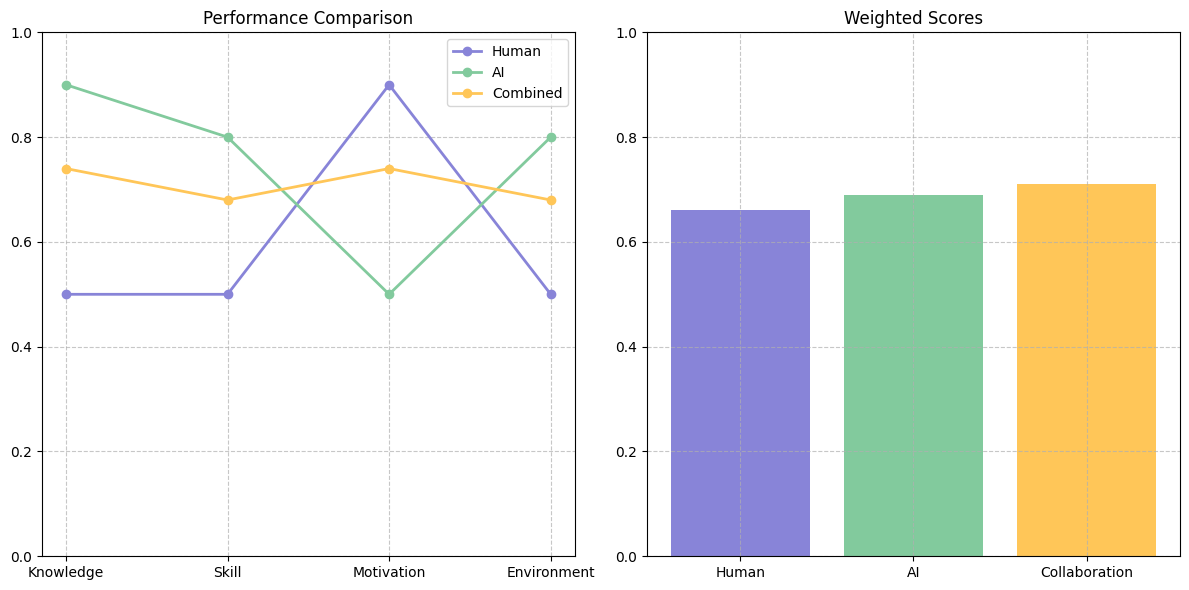

Human Score: 66.0%
AI Score: 69.0%
Collaboration Score: 71.0%


In [111]:
# 人与 AI 协作模拟器
class CollaborationSimulator:
    def __init__(self):
        # 初始化参数
        self.params = {
            # 人类能力
            'human_knowledge': 0.5,
            'human_skill': 0.5,
            'human_motivation': 0.9,
            'human_environment': 0.5,
            
            # AI能力
            'ai_knowledge': 0.9,
            'ai_skill': 0.8,
            'ai_motivation': 0.5,
            'ai_environment': 0.8,
            
            # 权重
            'weight_knowledge': 0.1,
            'weight_skill': 0.1,
            'weight_motivation': 0.4,
            'weight_environment': 0.4,
            
            # 协作效率
            'collaboration_efficiency': 0.5,
        }
        
        # 创建交互式控件
        self._create_widgets()
        
    def _create_widgets(self):
        """创建所有交互式控件"""
        style = {'description_width': 'initial'}
        layout = widgets.Layout(width='300px')
        
        # 人类能力滑块
        self.human_sliders = {
            'knowledge': widgets.FloatSlider(value=self.params['human_knowledge'], min=0, max=1, step=0.1,
                                           description='Human Knowledge', style=style, layout=layout),
            'skill': widgets.FloatSlider(value=self.params['human_skill'], min=0, max=1, step=0.1,
                                       description='Human Skill', style=style, layout=layout),
            'motivation': widgets.FloatSlider(value=self.params['human_motivation'], min=0, max=1, step=0.1,
                                            description='Human Motivation', style=style, layout=layout),
            'environment': widgets.FloatSlider(value=self.params['human_environment'], min=0, max=1, step=0.1,
                                             description='Human Environment', style=style, layout=layout)
        }
        
        # AI能力滑块
        self.ai_sliders = {
            'knowledge': widgets.FloatSlider(value=self.params['ai_knowledge'], min=0, max=1, step=0.1,
                                           description='AI Knowledge', style=style, layout=layout),
            'skill': widgets.FloatSlider(value=self.params['ai_skill'], min=0, max=1, step=0.1,
                                       description='AI Skill', style=style, layout=layout),
            'motivation': widgets.FloatSlider(value=self.params['ai_motivation'], min=0, max=1, step=0.1,
                                            description='AI Motivation', style=style, layout=layout),
            'environment': widgets.FloatSlider(value=self.params['ai_environment'], min=0, max=1, step=0.1,
                                             description='AI Environment', style=style, layout=layout)
        }
        
        # 权重滑块
        self.weight_sliders = {
            'knowledge': widgets.FloatSlider(value=self.params['weight_knowledge'], min=0, max=1, step=0.1,
                                           description='Weight Knowledge', style=style, layout=layout),
            'skill': widgets.FloatSlider(value=self.params['weight_skill'], min=0, max=1, step=0.1,
                                       description='Weight Skill', style=style, layout=layout),
            'motivation': widgets.FloatSlider(value=self.params['weight_motivation'], min=0, max=1, step=0.1,
                                            description='Weight Motivation', style=style, layout=layout),
            'environment': widgets.FloatSlider(value=self.params['weight_environment'], min=0, max=1, step=0.1,
                                             description='Weight Environment', style=style, layout=layout)
        }
        
        # 协作效率滑块
        self.efficiency_slider = widgets.FloatSlider(
            value=self.params['collaboration_efficiency'],
            min=0, max=1, step=0.01,
            description='Collaboration Efficiency',
            style=style,
            layout=layout
        )
        
        # 更新按钮
        self.update_button = widgets.Button(
            description='Update Visualization',
            layout=widgets.Layout(width='200px')
        )
        self.update_button.on_click(self.update_visualization)
        
    def calculate_scores(self):
        """计算人类、AI和协作得分"""
        dimensions = ['knowledge', 'skill', 'motivation', 'environment']
        c = self.efficiency_slider.value
        
        human_score = 0
        ai_score = 0
        collaboration_score = 0
        
        for dim in dimensions:
            human = self.human_sliders[dim].value
            ai = self.ai_sliders[dim].value
            weight = self.weight_sliders[dim].value
            
            human_score += weight * human
            ai_score += weight * ai
            collaboration_score += weight * (c * max(human, ai) + (1-c) * min(human, ai))
            
        return human_score, ai_score, collaboration_score
    
    def prepare_plot_data(self):
        """准备绘图数据"""
        dimensions = ['Knowledge', 'Skill', 'Motivation', 'Environment']
        human_values = [self.human_sliders[dim.lower()].value for dim in dimensions]
        ai_values = [self.ai_sliders[dim.lower()].value for dim in dimensions]
        c = self.efficiency_slider.value
        
        combined_values = [
            c * max(h, a) + (1-c) * min(h, a)
            for h, a in zip(human_values, ai_values)
        ]
        
        return dimensions, human_values, ai_values, combined_values
    
    def plot_results(self):
        """绘制结果图表"""
        dimensions, human_values, ai_values, combined_values = self.prepare_plot_data()
        human_score, ai_score, collab_score = self.calculate_scores()
        
        plt.figure(figsize=(12, 6))

        # 绘制折线图
        plt.subplot(1, 2, 1)
        plt.plot(dimensions, human_values, 'o-', label='Human', color='#8884d8', linewidth=2)
        plt.plot(dimensions, ai_values, 'o-', label='AI', color='#82ca9d', linewidth=2)
        plt.plot(dimensions, combined_values, 'o-', label='Combined', color='#ffc658', linewidth=2)
        plt.ylim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.title('Performance Comparison')
        
        # 绘制得分条形图
        plt.subplot(1, 2, 2)
        scores = [human_score, ai_score, collab_score]
        colors = ['#8884d8', '#82ca9d', '#ffc658']
        plt.bar(['Human', 'AI', 'Collaboration'], scores, color=colors)
        plt.ylim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title('Weighted Scores')
        
        plt.tight_layout()
        plt.show()
        
        # 打印具体分数
        print(f"Human Score: {human_score:.1%}")
        print(f"AI Score: {ai_score:.1%}")
        print(f"Collaboration Score: {collab_score:.1%}")
    
    def update_visualization(self, _=None):
        """更新可视化"""
        clear_output(wait=True)
        self.plot_results()
    
    def display_simulator(self):
        """显示模拟器"""
        # 创建三列布局
        human_box = widgets.VBox([widgets.HTML("<h3>Human Capabilities</h3>")] + 
                               list(self.human_sliders.values()))
        ai_box = widgets.VBox([widgets.HTML("<h3>AI Capabilities</h3>")] + 
                            list(self.ai_sliders.values()))
        params_box = widgets.VBox([widgets.HTML("<h3>Weights & Efficiency</h3>")] + 
                                list(self.weight_sliders.values()) + 
                                [self.efficiency_slider, self.update_button])
        
        # 显示控件
        display(widgets.HBox([human_box, ai_box, params_box]))
        self.plot_results()

# 创建并显示模拟器
simulator = CollaborationSimulator()
simulator.display_simulator()

#### 4.3.3 校准和优化模型
如果想继续提升协作水平，一个简单的办法是优化人与 AI 协作的“平衡系数”。若其它参数不变，仅将“平衡系数”改进至 0.6 ，就能让协作成绩到达 71 分，超过自身或 AI 独立完成这些任务的水平。可以说，发挥人与 AI 在各自擅长领域的优势，就是让生活更轻松的“时代红利”。
> Human Score: 66.0%
> AI Score: 69.0%
> Collaboration Score: 71.0%

那么，如何改进“平衡系数”呢？

##### 4.3.3.1 深入理解“平衡系数”
在模型公式中：$$ P = c \sum_{i=1}^n w_i \max(h_i, a_i) + (1-c) \sum_{i=1}^n w_i \min(h_i, a_i) $$

平衡系数 𝑐 决定了在协作中对人类与 AI 各自优势（通过 $max(h_i, a_i)$ 表示）与劣势（通过 $min(h_i, a_i)$ 表示）的权重分配。具体来说，𝑐 越大，模型越倾向于强调双方在各维度上的最佳表现；反之，1−𝑐 越大，则越关注双方在各维度上的最低表现。
𝑐 的设置反映了协作中对发挥优势与控制风险的平衡。例如，较高的 𝑐 值意味着更强调发挥人类或 AI 在各维度上的优势，从而带来更高的协作绩效；而较低的 𝑐 值则可能更注重避免因某一方能力不足而导致的任务失败风险。

一种改进“平衡系数”的思路是：$$ P = \sum_{i=1}^n[ c_i w_i \max(h_i, a_i) + (1-c_i) w_i \min(h_i, a_i)] $$
针对不同的能力维度（知识、技能、动机、环境），分别设定平衡系数 $c_i$ 。独立的 $c_i$ 允许更精细地优化每个维度的协作策略。

假设将 𝑐 细化成四个维度：
- 'c_knowledge': 0.9*80%    # 知识方面充分信任 AI，至少做到 $a_i$ 的 80%
- 'c_skill': 0.8*80%        # 对不擅长的技能，特别使用「计算智能」，要请 AI 提供 step by step 指导，争取做到 $a_i$ 的 80% 
- 'c_motivation': 0.9       # 使用人类在动机维度的取值 $h_i$，保持人之为人的优势
- 'c_environment': 0.8*80%  # 充分借助与 AI 相关的进步力量，争取做到 $a_i$ 的 80%
对 𝑐 加权求和可得：(0.9*80%*0.1)+(0.8*80%*0.1)+(0.9*0.4)+(0.8*80%*0.4)= 0.752 。
将 𝑐 带入模型重新推导可知：协作成果已提升至 76 分。

### 4.4 重新制订提案
围绕「协作」模型，重新制订提案

In [100]:
# 制订有关{subject_text}的提案

subject_text = "如何与 LLMs 协作，让生活更轻松"
draft_proposal_user_prompt = f"""{subject_text}"""

messages = [
    {"role": "system", "content": draft_proposal_system_prompt},
    {"role": "user", "content": draft_proposal_user_prompt}
]

OPENROUTER_MODEL = "anthropic/claude-3.5-sonnet:beta" # openai/gpt-4o-2024-11-20
extracted_data = await call_llm(messages)

In [ ]:
updater = NotebookUpdater(model_name=OPENROUTER_MODEL)
title = f"#### 4.4.1 {OPENROUTER_MODEL} 生成"
updater.update_markdown(title, extracted_data)

#### 4.4.1 anthropic/claude-3.5-sonnet:beta 生成

让我基于框架为您分析如何与 LLMs 更好地协作。

##### 厘清概念
- LLMs(Large Language Models)是基于深度学习的自然语言处理模型，能够理解、生成和交互自然语言
- 与 LLMs 协作是指人类利用 LLMs 的知识和处理能力，同时发挥人类的判断力和创造力，共同完成任务
- 在人机协作模型中，LLMs 在知识(K)、技能(S)和环境适应性(E)方面具有优势，而人类在动机(M)方面具有优势

##### 分析现状
知识维度(K):
- LLMs: 拥有海量知识储备(0.9)
- 人类: 知识有限且易遗忘(0.5)
- 差距: 人类需要频繁查询和更新知识

技能维度(S):
- LLMs: 快速处理和分析能力强(0.8)
- 人类: 执行效率相对较低(0.5)
- 差距: 人类单独完成任务耗时较多

动机维度(M):
- LLMs: 缺乏主观能动性(0.5)
- 人类: 具有明确目标和意愿(0.9)
- 优势: 人类可以引导协作方向

环境维度(E):
- LLMs: 全天候可用，反应迅速(0.8)
- 人类: 受时间空间限制(0.5)
- 差距: 人类需要更好地利用 LLMs 的可及性

##### 设定目标
北极星指标：协作效率提升度
- 完成相同任务所需时间减少50%
- 任务完成质量提升30%
- 心智负担降低40%

次级指标：
- 提示词精准度
- 输出结果可用性
- 协作流程顺畅度

##### 规划路径

可能的干扰：
1. 提示词表达不清导致输出偏离预期
2. 过度依赖 LLMs 而忽视人类判断
3. 协作流程不够流畅影响效率

克服方案：
1. 建立个人提示词模板库
2. 设定明确的任务边界和决策权限
3. 设计标准化的协作流程

##### 分阶段任务列表

第一阶段：基础建设（1-2周）
- 整理常用生活场景清单
- 建立个人提示词模板库
- 设计基础协作流程

第二阶段：能力提升（2-4周）
- 练习提示词编写和优化
- 熟悉 LLMs 的特点和限制
- 建立快速反馈机制

第三阶段：深度协作（4-8周）
- 将 LLMs 整合入日常工作流
- 持续优化协作模式
- 量化协作成效

##### 注意事项

1. 专注于提升协作效率，而不是单独提升人或 AI 的能力
2. 保持"人类主导、AI 协助"的定位
3. 根据任务特点灵活调整协作方式
4. 持续记录和总结协作经验
5. 注意隐私和安全边界

通过以上方案，我们可以充分发挥人类在动机方面的优势(0.9)和 LLMs 在知识(0.9)、技能(0.8)和环境适应性(0.8)方面的优势，实现协作效果最大化。关键是要通过良好的协作流程和持续的优化，将平衡系数从默认的0.5提升到更理想的水平(0.64-0.9)，从而实现"1+1>2"的效果。

#### 4.4.2 openai/gpt-4o-2024-11-20 生成

##### 提案：如何与 LLMs (大型语言模型) 协作，让生活更轻松

---

##### 1. **厘清概念**
与 LLMs 协作是指在人类日常生活中，借助像 ChatGPT 这样的语言模型，与其配合来高效解决问题、减少负担，并改善工作与生活质量。根据**人机协作模型**，协作的成效（Performance）是人和 AI 各自能力加权贡献的组合。  
- **人类的强项**：动机突出（Motivation=0.9），个性化需求更明确（如生活目标的驱动力）。  
- **LLMs 的强项**：知识全面且快（Knowledge=0.9）、技能结构完善（Skill=0.8）和对执行环境的适应性高（Environment=0.8）。  
- **协作的关键**在于平衡系数 $c$，需要针对不同任务充分利用双方的独特优势（如让 LLMs 提供智能支持，同时保持人的主导性）。

---

##### 2. **分析现状**
##### 为什么要与 LLMs 协作？
当前的日常生活中，面对繁杂事务（如规划日程、任务管理、信息查询、学习进步、甚至情感支持），人们容易消耗大量精力和时间。而 LLMs 在知识、技能与效率上的优势，可以减轻人的负担，提高生活质感。

从 KSME 四个维度看现状：
- **Knowledge (知识)**：普通人对事项的了解通常片面或有限，而 LLMs 基于庞大的训练数据，可以快速补充和提供提炼的知识资源。  
- **Skill (技能)**：人类通常擅长处理核心事务的专业技能，但可能缺乏高效信息组织、计划编排等工具化技能，而 LLMs 可以很好填补这一缺失。  
- **Motivation (动机)**：人类对生活提质有内生驱动力，但动机有时候会因任务的繁杂性削弱，LLMs 没有内驱动力，但可以随时完成催化性的执行任务。  
- **Environment (环境适应)**：LLMs 能快速适用于不同领域，但人对多变环境有更强烈的体验感和主观能动性。

**现状痛点**：  
- 分工与优势没有得到最大化利用。人可能浪费时间处理信息冗余或机械性任务，而 LLMs 的潜力未被充分调用。  
- 协作的平衡系数未优化，任务分配与工具化应用不足，容易导致低效协作。  

---

##### 3. **设定目标**
**实现生活更轻松的核心目标**是让 LLMs 成为辅助“伙伴”而非“工具”。通过人机协作，不仅完成日常事务，还提升效率与幸福感。  

##### 指标体系 ####
- **任务完成效率**（K+S 优化协作程度）  
- **人类专注时间**（释放人类专精优势的程度，更多时间用于核心事务或休息）  
- **情绪压力减少**（Motivation 维度是否得以增强）  
- **生活满意度的提升**（是否更好适应生活环境）  

**北极星指标**：协作性任务的整体时间成本至少减少 30%，同时任务完成质量（如计划精准性或信息全面性）提升显著。  

---

##### 4. **规划路径**

##### 干扰因素 ####
1. **知识与技能的过渡依赖**：过于依赖 LLMs 可能导致个人失去主动思考能力。  
2. **指令模糊导致的误解与低效**：人与 LLMs 的交互质量不足会降低效能。  
3. **心理接受度**：部分人可能因为对 AI 的陌生感，不信任它，或过于担忧其取代性。  

##### 克服策略 ####
1. **明确分工与边界**：  
   - 将 LLMs 视为“助手”，交给它重复性、机械性任务（如日程安排），保留人类主观决策与创造性任务的领导权。  
   - 建立“协作模板”，明确哪些任务更适合交由 LLMs。  

2. **提升沟通能力**：  
   - 学会与 LLMs 用清晰的自然语言交互，通过逐步明确指令优化输出结果，避免错误内容输出。  
   - 善用上下文功能，让 LLMs 提供连续支持（如：大任务分解、生命周期管理等）。  

3. **调节心理接受度**：  
   - 了解 LLMs 的局限性，它只是一种无偏智能体，无法替代人类个性化判断，因此不必对其结果有绝对依赖或担忧。  
   - 通过小任务逐步融入，以降低使用门槛和心理压力。  

---

##### 5. **分阶段任务列表**

**第 1 阶段：基础协作 - 初步熟悉工具**  
任务：简单日常事务应用，如查找资料、制作清单、生成简短计划。  
- 示例任务：  
  1. 用 LLMs 规划一周的阅读计划及目标。  
  2. 询问 AI 提供某活动所需物品清单或问题解答。

**第 2 阶段：提升协作 - 复杂任务拆解**  
任务：引入较复杂的协作性任务，充分利用人和 AI 各自优势。  
- 示例任务：  
  1. 制定旅行计划（人类决定目的地和偏好，LLMs 安排行程细节）。  
  2. 协助完成日常琐碎任务整合（待办事项与优先排名）。  

**第 3 阶段：优化协作 - 强化分工与紧密配合**  
任务：优化高负载任务处理、人机交互脚本，打造“生活指挥中心”。  
- 示例任务：  
  1. 用 LLMs 做未来 1 年财务预算建议，具体任务由人逐一调整落实。  
  2. 利用 AI 自动生成和分享信息模板（如电邮、邀约或者内容草稿）。  

---

##### 6. **注意事项**
1. 不要试图通过强化自身或 LLMs 的单一维度能力来改善协作效果，而是注重平衡和分工优化。  
2. 提高平衡系数关键点在于：保留人类的动机核心（如决策和目的设定），并激发 LLMs 在知识、技能和环境上的支持潜能。  
3. 避免使用 LLMs 应对完全不适应的任务（如创造性非结构化复杂情感活动），以免浪费时间或产生挫败感。  
4. 定期回顾评价协作成效，根据 KSME 各维度优化具体任务的协作模式。

---

通过明确分工与策略性提升平衡系数，你将发现 LLMs 不只是工具，而是协作伙伴，从而真正实现生活的**高效与轻松**。

### 4.5 小结
在我们看来，将“平衡系数”提升至 80 分，并创造一个 80 分的协作成果，是任何普通人够一够都能达成的目标，是时代赋予我们每个人的红利。
- 如果你有足够的时间，不妨参考和尝试 AI 给出的任务清单。
- 反之，也可以直接参考我们与 AI 的协作笔记，并在此基础上形成自己的版本，那样会更轻松。


## 5 更多协作，让生活更轻松
应用以上方法，与 AI 协作完成更多生活事务。

### 5.1 生活拼图

### 5.2 审查人生

### 5.3 成为你自己